In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns

In [3]:
import pandas as pd

In [62]:
sns.set_context('paper', font_scale=2.2)
sns.set_style('ticks')

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import rough_front_expansion.cython as rfe

In [64]:
import skimage as ski
import skimage.morphology

In [65]:
nx = 500 # width
ny = 500 # max length to expand

num_strains = 2 # Number of competing strains

# Creating the initial condition. A line of competing strain 0 and 1
ic_lattice = -1*np.ones((nx, ny), dtype=np.int32)

ic_lattice[:, 0] = 0 
ic_lattice[220:280, 0] = 1

# The velocities of the two strains. 
v = np.array([1.0, 1.05], dtype=np.float)

To test how it looks...

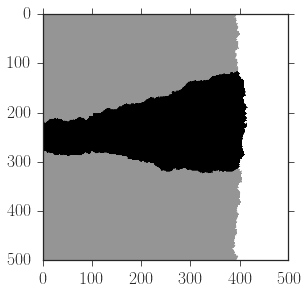

In [66]:
seed = np.random.randint(2**32 - 1)

sim = rfe.Rough_Front(nx=nx, ny=ny, num_strains=2, v=v, ic=ic_lattice, seed=seed, debug=False)

sim.run(sim.max_iterations/1.25)

plt.imshow(sim.lattice)

We now run many simulations and extract the domain walls using the "get_wall_df" script from the utility file which I import as "uti." I run until the domain is completely filled.

In [67]:
import rough_front_expansion.utility as uti

In [68]:
times_to_run = 10

In [69]:
df_list = []

for i in range(times_to_run):
    seed = np.random.randint(2**32 - 1)

    sim = rfe.Rough_Front(nx=nx, ny=ny, num_strains=2, v=v, ic=ic_lattice, seed=seed, debug=False)
    
    sim.run(sim.max_iterations)
    
    wall_df = uti.get_wall_df(sim, 0, 1, expansion_size=1, single_sector=True)
    
    wall_df.sort_values(['label_num', 'c', 'r'], inplace=True)
    
    wall_df['sim_num'] = i
    
    df_list.append(wall_df)
df = pd.concat(df_list)

Ran for the maximum number of iterations! Done.
Ran for the maximum number of iterations! Done.
Ran for the maximum number of iterations! Done.
Ran for the maximum number of iterations! Done.
Ran for the maximum number of iterations! Done.
Ran for the maximum number of iterations! Done.
Ran for the maximum number of iterations! Done.
Ran for the maximum number of iterations! Done.
Ran for the maximum number of iterations! Done.
Ran for the maximum number of iterations! Done.


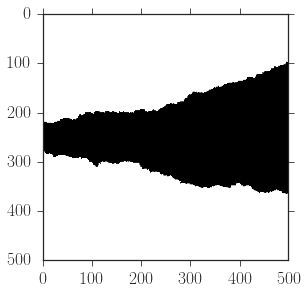

In [70]:
plt.imshow(np.asarray(sim.lattice))

We now plot the domain trajectories...

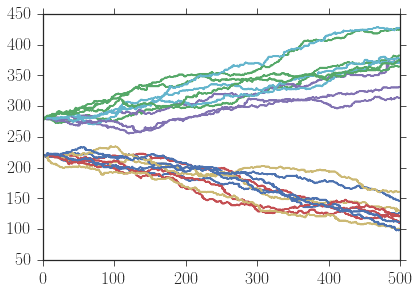

In [71]:
for name, cur_data in df.groupby(['sim_num','label_num']):
    x = cur_data['c'].values
    y = cur_data['r'].values
    plt.plot(cur_data['c'], cur_data['r'])

We now average the domain wall position at each length expanded. FYI, the "dataframe" containing the domain walls is

In [72]:
df.head(10) # Print the first 10 rows
# c: x position
# i,j: type of domain wall, i.e. strain i intersecting with strain j
# r: y position
# sim_num: the simulation number

,c,i,j,label_num,r,sim_num
1110,0,0,1,1,219,0
1115,0,0,1,1,220,0
1111,1,0,1,1,219,0
1116,1,0,1,1,220,0
1095,2,0,1,1,218,0
1112,2,0,1,1,219,0
1096,3,0,1,1,218,0
1113,3,0,1,1,219,0
1077,4,0,1,1,217,0
1097,4,0,1,1,218,0


In [73]:
binned_df = df.groupby(['sim_num', 'label_num', 'i', 'j', 'c']).agg(np.mean).reset_index()

We now get the distance between each domain as a function of length expanded.

In [74]:
result_list = []

for name, cur_data in binned_df.groupby(['sim_num', 'i', 'j']):
    
    lab1 = cur_data.loc[cur_data['label_num'] == 1]    
    lab2 = cur_data.loc[cur_data['label_num'] == 2]
    
    if len(lab1 !=0) and len(lab2 !=0):
    
        y1 = lab1['r'].values
        y2 = lab2['r'].values

        width = y2 - y1
        delta_x = width - width[0]
        
        x = lab1['c'].values
        
        temp_df = pd.DataFrame(data={'x':x,'width':width, 
                                     'delta_x':delta_x})
        temp_df['sim_num'] = name[0]
        temp_df['i' ] = name[1]
        temp_df['j'] = name[2]
        
        result_list.append(temp_df)
        
    else:
        print 'Domain walls collided and were not corrected!'

In [75]:
width_df = pd.concat(result_list)

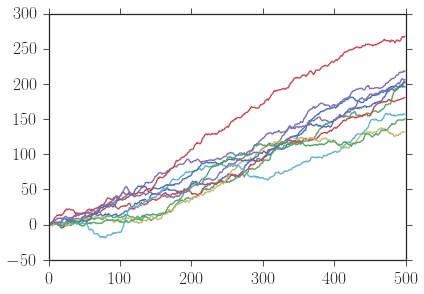

In [76]:
for name, cur_data in width_df.groupby(['sim_num']):
    plt.plot(cur_data['x'], cur_data['delta_x'])

We average the width vs. length expanded, and test if it meets geometrical predictions.

0.320156211872


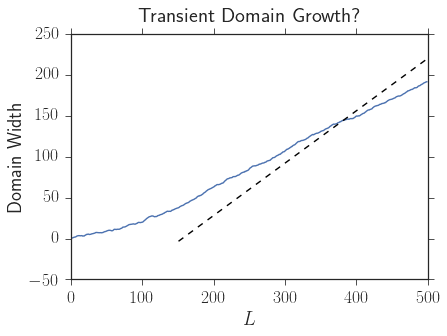

In [77]:
av_df = width_df.groupby(['x']).agg([np.mean, np.var]).reset_index()

plt.plot(av_df['x'], av_df['delta_x', 'mean'])

# Get the expected slope...
s = v[1]/v[0] - 1
vw1 = np.sqrt(s*(2+s))
print vw1

xtest = av_df['x'].values
ytest = 2*vw1*xtest - 100

to_keep = xtest > 150
xtest = xtest[to_keep]
ytest = ytest[to_keep]

plt.plot(xtest, ytest, ls='--', color='black')
#plt.ylim(0, 200)

plt.xlabel(r'$L$')
plt.ylabel(r'Domain Width')
plt.title('Transient Domain Growth?', y = 1.03)
plt.savefig('transient_domain_growth_large_fitness.pdf', bbox_inches='tight')
#plt.plot(av_df['x'], 10*s*av_df['x'], ls='--', color='black')

For fun, we can interpolate this function and plot "wall velocity" vs. length expanded and evaluate its derivative.

In [78]:
import scipy as sp

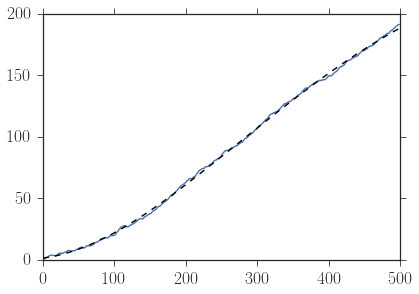

In [84]:
x_sim = av_df['x'].values
y_sim = av_df['delta_x', 'mean']

interp = sp.interpolate.UnivariateSpline(x_sim, y_sim, s=1000.)

# Plotting simulation data
plt.plot(x_sim, y_sim)

# Plotting the smooth interpolant

plt.plot(x_sim, interp(x_sim), ls='--', color='black')

Plotting the smoothed derivative and testing it with geometric predictions,

In [85]:
vw1

0.32015621187164256

In [86]:
plt.rc('text', usetex=True)

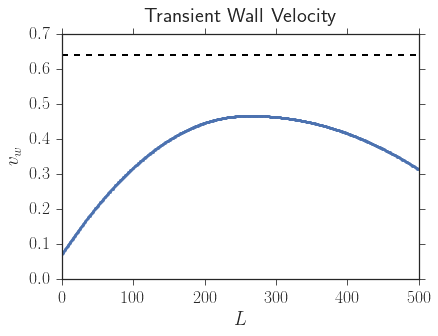

In [87]:
der = interp.derivative()

plt.plot(x_sim, der(x_sim), ls='-', marker='.', label='Simulation')

# Geometrical prediction
s = v[1]/v[0] - 1
vw1 = np.sqrt(s*(2+s))

plt.hlines(2*vw1, 0, ny, color='black', linestyles='--', label='Geometric Optics', lw=2)

plt.ylabel(r'$v_w$')
plt.xlabel(r'$L$')
plt.title('Transient Wall Velocity', y=1.03)

I attribute the ultimate disagreement of wall velocity with the exact geometric prediction to lattice artifacts.

# Testing that the walls diffusion scaled in a KPZ way

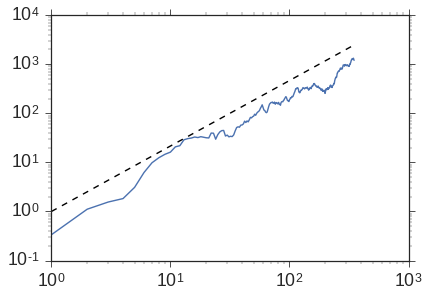

In [26]:
av_df = width_df.groupby(['x']).agg([np.mean, np.var]).reset_index()

plt.loglog(av_df['x'], av_df['delta_x', 'var'])

power = 4./3.

plt.loglog(av_df['x'], av_df['x']**power, color='black', ls='--')

Looks good, matches a 4/3 exponent. Scaling is as expected, although the selective advantage certainly changes the magnitude.